<a href="https://colab.research.google.com/github/samleonnn/waste-segregation/blob/main/WasteSegregation_TransferLearning_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Capstone C22-PC414/AllMainData_v3.zip", "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
TRAIN_DIR = "/tmp/AllMainData_v3/TRAIN"
VAL_DIR  = "/tmp/AllMainData_v3/VAL"

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                    batch_size=128, 
                                    class_mode="categorical",
                                    target_size=(224, 224))

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.5)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(224, 224),
                                            subset = "training",
                                            shuffle = False)

test_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(224, 224),
                                            subset = "validation",
                                            shuffle = False)

Found 21249 images belonging to 3 classes.
Found 3212 images belonging to 3 classes.
Found 3211 images belonging to 3 classes.


In [6]:
print(train_generator.class_indices)

{'Non-Recyclable': 0, 'Organic': 1, 'Recyclable': 2}


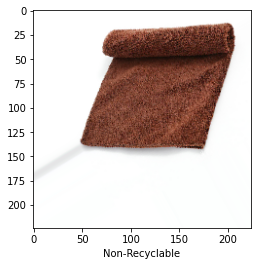

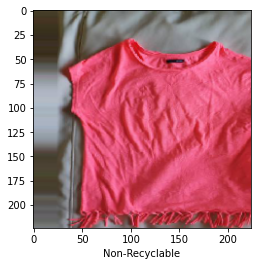

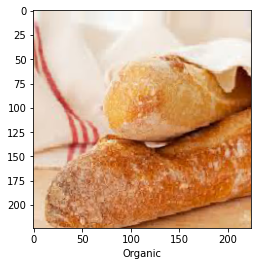

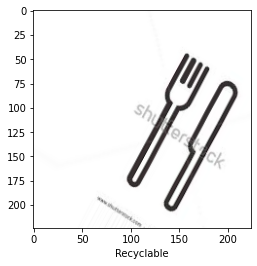

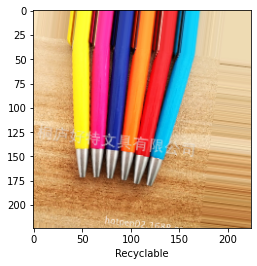

In [7]:
class_names = ["Non-Recyclable", "Organic", "Recyclable"]
x,y = train_generator.next()

for i in range(5):
    image = x[i]
    label = np.argmax(y[i])
    plt.xlabel(class_names[label])
    plt.imshow(image)
    plt.show()

In [8]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras import layers

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3))

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [9]:
print('last layer output shape: ', pre_trained_model.output_shape)
last_output = pre_trained_model.output

last layer output shape:  (None, 7, 7, 1024)


In [10]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [11]:
opt = "adam"

model.compile(optimizer=opt,
            loss="categorical_crossentropy",
            metrics=['accuracy']) 

In [12]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = validation_generator)

Epoch 1/10
167/167 [==============================] - 328s 2s/step - loss: 1.5561 - accuracy: 0.7856 - val_loss: 0.4030 - val_accuracy: 0.8225
Epoch 2/10
167/167 [==============================] - 305s 2s/step - loss: 0.3548 - accuracy: 0.8619 - val_loss: 0.4576 - val_accuracy: 0.8266
Epoch 3/10
167/167 [==============================] - 301s 2s/step - loss: 0.3406 - accuracy: 0.8688 - val_loss: 0.6841 - val_accuracy: 0.7733
Epoch 4/10
167/167 [==============================] - 301s 2s/step - loss: 0.3219 - accuracy: 0.8731 - val_loss: 0.3788 - val_accuracy: 0.8512
Epoch 5/10
167/167 [==============================] - 302s 2s/step - loss: 0.2934 - accuracy: 0.8848 - val_loss: 0.3685 - val_accuracy: 0.8639
Epoch 6/10
167/167 [==============================] - 302s 2s/step - loss: 0.2807 - accuracy: 0.8919 - val_loss: 0.3771 - val_accuracy: 0.8531
Epoch 7/10
167/167 [==============================] - 303s 2s/step - loss: 0.2610 - accuracy: 0.8980 - val_loss: 0.3362 - val_accuracy: 0.8649

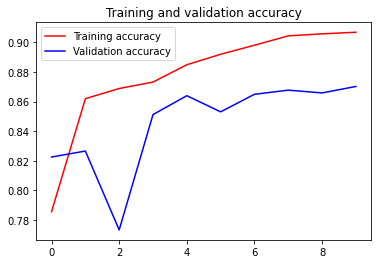

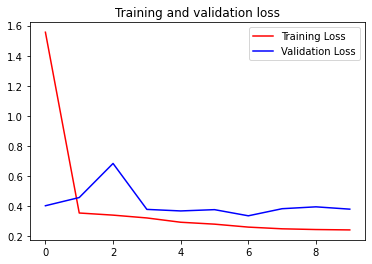

In [13]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(test_generator)

26/26 [==============================] - 16s 618ms/step - loss: 0.1764 - accuracy: 0.9396


[0.17643031477928162, 0.9395827054977417]

Confusion Matrix


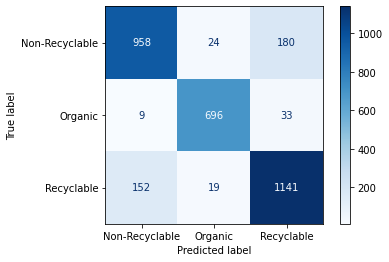


Classification Report
                precision    recall  f1-score   support

Non-Recyclable       0.86      0.82      0.84      1162
       Organic       0.94      0.94      0.94       738
    Recyclable       0.84      0.87      0.86      1312

      accuracy                           0.87      3212
     macro avg       0.88      0.88      0.88      3212
  weighted avg       0.87      0.87      0.87      3212



In [15]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(validation_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))   

In [16]:
save_path = "/content/drive/MyDrive/Capstone C22-PC414/wsmodel-22052022-mobilenet10"
model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone C22-PC414/wsmodel-22052022-mobilenet10/assets
